In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Concatenate, Input, Flatten, Lambda, Reshape
from keras.layers.embeddings import Embedding

In [3]:
df = pd.read_csv('./car.data', header=None)
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "target"]
categorical_vars = df.columns[:-1]
for cat_var in df.columns:
	df[cat_var] = df[cat_var].astype("category")

In [4]:
for cat_var in df.columns:
	print(cat_var, dict(enumerate(df[cat_var].cat.categories)))
	df[cat_var] = df[cat_var].cat.codes

buying {0: 'high', 1: 'low', 2: 'med', 3: 'vhigh'}
maint {0: 'high', 1: 'low', 2: 'med', 3: 'vhigh'}
doors {0: '2', 1: '3', 2: '4', 3: '5more'}
persons {0: '2', 1: '4', 2: 'more'}
lug_boot {0: 'big', 1: 'med', 2: 'small'}
safety {0: 'high', 1: 'low', 2: 'med'}
target {0: 'acc', 1: 'good', 2: 'unacc', 3: 'vgood'}


In [5]:
print(df.shape)
df.head()

(1728, 7)


,buying,maint,doors,persons,lug_boot,safety,target
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [6]:
np.random.seed(10001)
df_train = df.sample(frac=0.8)
df_test = df.drop(df_train.index, axis=0)


X_train = df_train.drop("target", axis=1)
y_train = df_train["target"].values

X_test = df_test.drop("target", axis=1)
y_test = df_test["target"].values

In [7]:
X_train_preprocessed = []
for c in X_train.columns:
	X_train_preprocessed.append(X_train[c].to_numpy())
X_test_preprocessed = []
for c in X_test.columns:
	X_test_preprocessed.append(X_test[c].to_numpy())

In [ ]:
embedding_size = 4
ins = []
embedded_models = []
for cat_var in categorical_vars:
	_input = Input(shape=(1,), name=cat_var)
	ins.append(_input)
	k = df_train[cat_var].nunique()
	_embedded = Embedding(k, embedding_size, input_length=1, name=cat_var + "_embedded")(_input)
	embedded_models.append(_embedded)
x = Concatenate()(embedded_models)
x = Flatten()(x)
for _ in range(4):
	x = Dense(200, activation="relu")(x)
outs = Dense(4, activation="softmax")(x)
model = keras.Model(inputs=ins, outputs=outs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(x=X_train_preprocessed, y=y_train, epochs = 50, batch_size = 4, callbacks=[callback], validation_split=0.1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].plot(history.epoch, history.history['val_accuracy'], label='Validation')
axs[1].plot(history.epoch, history.history['accuracy'], label='Training')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlim(left=0, right=history.epoch[-1])
baseline_acc = (np.bincount(y_train) / len(y_train)).max().round(3)
axs[1].axhline(baseline_acc, ls='--', label='Baseline', color='#002255', alpha=0.5)
fig.legend(labelcolor='linecolor')

## All-predictor model (for scalar multiplication)

In [8]:
embedding_size = 4
ins = []
sub_models = []
for cat_var in categorical_vars:
	_input = Input(shape=(1,), name=cat_var)
	ins.append(_input)
	k = df_train[cat_var].nunique()
	_embedded = Embedding(k, embedding_size, input_length=1, name=cat_var + "_embedded")(_input)
	_embedded = Reshape(target_shape=(embedding_size,))(_embedded)
	sub_model = Lambda(lambda x: tf.multiply(x[0], x[1]), name=cat_var + "_mult")([_input, _embedded])
	sub_models.append(sub_model)
x = Concatenate()(sub_models)
for _ in range(4):
	x = Dense(200, activation="relu")(x)
outs = Dense(4, activation="softmax")(x)
model = keras.Model(inputs=ins, outputs=outs)

2022-06-08 23:44:42.776413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(x=X_train_preprocessed, y=y_train, epochs = 50, batch_size = 4, callbacks=[callback], validation_split=0.1)

Epoch 1/50
311/311 [==============================] - 2s 4ms/step - loss: 0.9519 - accuracy: 0.6887 - val_loss: 0.7081 - val_accuracy: 0.7410
Epoch 2/50
311/311 [==============================] - 1s 3ms/step - loss: 0.6511 - accuracy: 0.7265 - val_loss: 0.5219 - val_accuracy: 0.7914
Epoch 3/50
311/311 [==============================] - 1s 3ms/step - loss: 0.4608 - accuracy: 0.8126 - val_loss: 0.3732 - val_accuracy: 0.8417
Epoch 4/50
311/311 [==============================] - 1s 3ms/step - loss: 0.3466 - accuracy: 0.8504 - val_loss: 0.2831 - val_accuracy: 0.8777
Epoch 5/50
311/311 [==============================] - 1s 3ms/step - loss: 0.2825 - accuracy: 0.8721 - val_loss: 0.2400 - val_accuracy: 0.8705
Epoch 6/50
311/311 [==============================] - 1s 3ms/step - loss: 0.2316 - accuracy: 0.9083 - val_loss: 0.1869 - val_accuracy: 0.9137
Epoch 7/50
311/311 [==============================] - 1s 3ms/step - loss: 0.1963 - accuracy: 0.9244 - val_loss: 0.1676 - val_accuracy: 0.9424
Epoch 

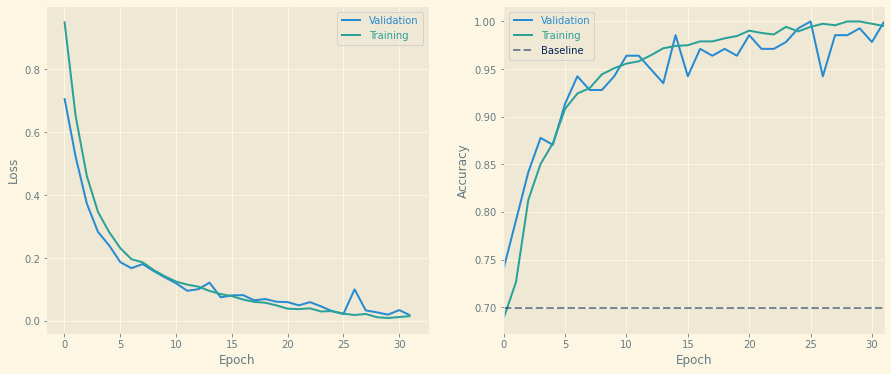

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(history.history['val_loss'], label="Validation")
axs[0].plot(history.history['loss'], label="Training")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(labelcolor='linecolor')
axs[1].plot(history.epoch, history.history['val_accuracy'], label='Validation')
axs[1].plot(history.epoch, history.history['accuracy'], label='Training')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlim(left=0, right=history.epoch[-1])
baseline_acc = (np.bincount(y_train) / len(y_train)).max().round(3)
axs[1].axhline(baseline_acc, ls='--', label='Baseline', color='#002255', alpha=0.5)
axs[1].legend(labelcolor='linecolor')

In [16]:
yh_test = model.predict(x=X_test_preprocessed).argmax(axis=1)
(yh_test == y_test).mean().round(3)

11/11 [==============================] - 0s 2ms/step


0.988

**Convert one-hot to embedding vectors**

In [ ]:
layer = model.get_layer('buying_embedded')
output_concat_embeddings = layer.get_weights()
print(output_concat_embeddings[0])

In [ ]:
M = output_concat_embeddings[0][:4,:]
M

In [ ]:
pd.get_dummies(X_train["buying"])

In [ ]:
pd.DataFrame(pd.get_dummies(X_train["buying"]).values.dot(M), columns=["buying_embedded_" + str(i) for i in range(4)], index=X_train.index)

In [ ]:
dfs = []
for cat_var in categorical_vars:
	layer = model.get_layer(cat_var + "_embedded")
	output_concat_embeddings = layer.get_weights()
	k = output_concat_embeddings[0].shape[0] - 1
	M = output_concat_embeddings[0][:k,:]
	_df = pd.DataFrame(pd.get_dummies(X_train[cat_var]).values.dot(M), columns=[cat_var + "_embedded_" + str(i) for i in range(4)], index=X_train.index)
	dfs.append(_df)

X_train_embd_transformed = pd.concat(dfs, axis=1)

In [ ]:
print(X_train_embd_transformed.shape)
X_train_embd_transformed.head()

**extract weight sketch**

In [29]:
dfs = []
for layer in model.layers:
	if isinstance(layer, Embedding):
		M = layer.get_weights()[0]
		k = M.shape[0]
		layer_name = layer.name
		cat_var = layer_name[:-9]
		_df = pd.DataFrame(pd.get_dummies(X_train[cat_var]).values.dot(M), columns=[layer_name + str(i) for i in range(4)], index=X_train.index)
		dfs.append(_df)